In [7]:
import sys 
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import gc

from modules import get_model
from modules_kvcache import get_causal_kv_model

DEVICE="cuda"

In [8]:
dic_model_colors = {
    "CausalRevIN":  "#573030FF",  # semi-transparent brown
    "RevIN":         "#0055FF",  # electric deep blue
    "PrefixRevIN":      "#CC0099",  # strong magenta
    "KVCacheCausalRevIN": "#573030FF",  # vibrant green
}

dic_model_symbols = {
    "CausalRevIN":  "x",   # cross
    "RevIN":         "d",   # diamond
    "PrefixRevIN":      "v",   # triangle down
    "KVCacheCausalRevIN": "o",   # circle
}

labels = {
    "CausalRevIN":  r"Causal + $\sinh^{-1}$",
    "RevIN":         r"RevIN + $\sinh^{-1}$",
    "PrefixRevIN":      r"Prefix@k + $\sinh^{-1}$",
    "KVCacheCausalRevIN": r"Causal + $\sinh^{-1}$ + KV Cache",
}

works only for CausalRevIN. Currently with asinh


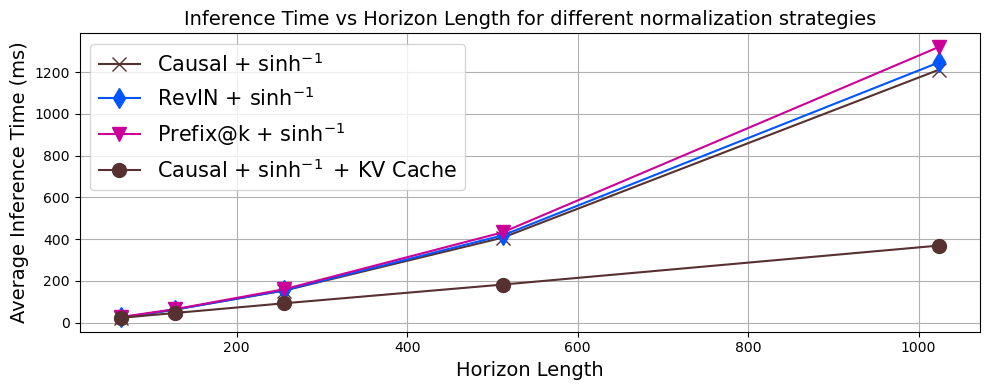

works only for CausalRevIN. Currently with asinh


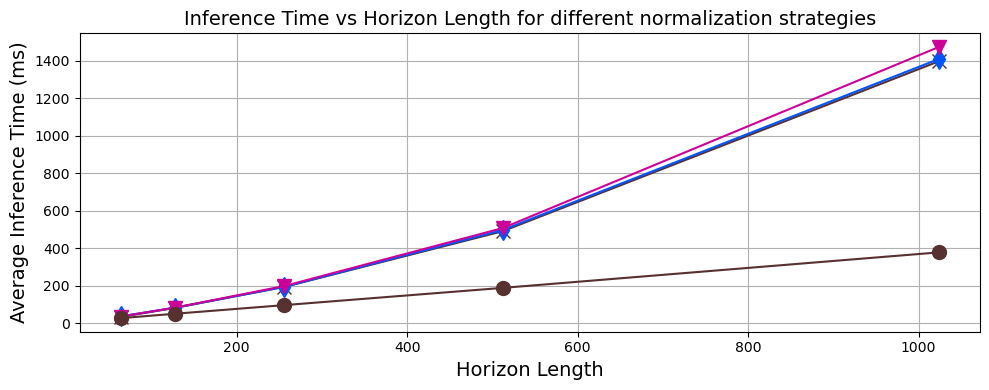

works only for CausalRevIN. Currently with asinh


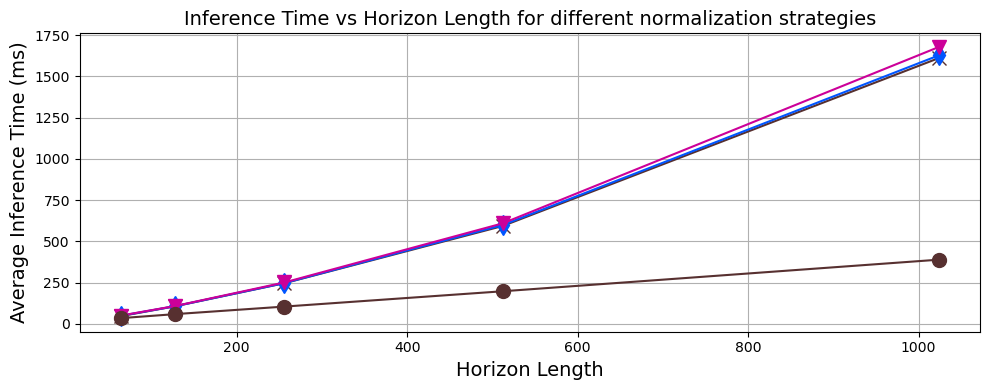

works only for CausalRevIN. Currently with asinh


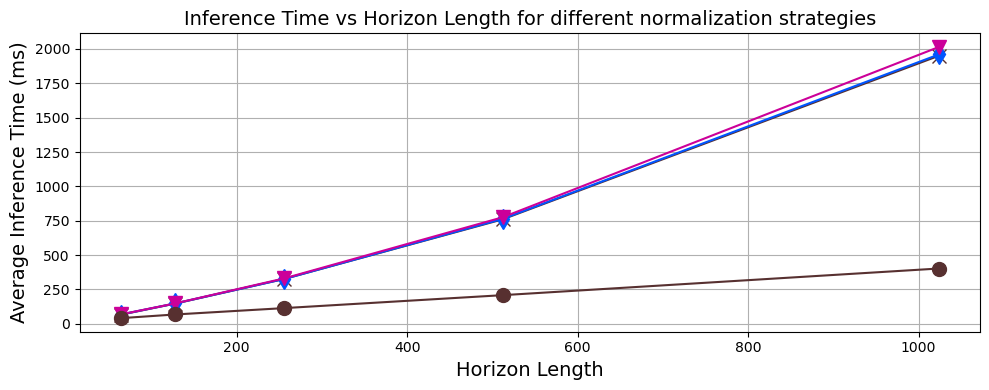

In [9]:
horizons = [64, 128, 256, 512, 1024]
context_lens = [128, 256, 512, 1024]
n_runs = 5

rev_strategies = ["CausalRevIN", "RevIN", "PrefixRevIN", "KVCacheCausalRevIN"]

speed = {h: {s:[] for s in rev_strategies} for h in horizons}

with torch.no_grad():
    for context_len in context_lens:
        x = torch.randn(10, context_len).to(DEVICE)
        for rev_strategy in rev_strategies:

            if rev_strategy == "KVCacheCausalRevIN":
                model = get_causal_kv_model(device=DEVICE)
            else:
                model = get_model(revin_strategy=rev_strategy, use_asinh=True, device=DEVICE)

            for target_len in horizons:

                # Warmup (VERY IMPORTANT)
                for _ in range(3):
                    model.forecast(x, target_len=target_len)

                for run in range(n_runs):

                    start = torch.cuda.Event(enable_timing=True)
                    end = torch.cuda.Event(enable_timing=True)

                    torch.cuda.empty_cache()
                    torch.cuda.reset_peak_memory_stats()

                    start.record()
                    model.forecast(x, target_len=target_len)
                    end.record()
                    torch.cuda.synchronize()

                    elapsed_time = start.elapsed_time(end)  # Time in milliseconds
                    speed[target_len][rev_strategy].append(elapsed_time)
            torch.cuda.empty_cache()
            gc.collect()
            

        plt.figure(figsize=(10, 4))
        for rev_strategy in rev_strategies:
            means = [np.mean(speed[h][rev_strategy]) for h in horizons]
            plt.plot(horizons, means, marker=dic_model_symbols[rev_strategy], color=dic_model_colors[rev_strategy], label=labels[rev_strategy], markersize=10)
        plt.xlabel('Horizon Length', fontsize=14)
        plt.ylabel('Average Inference Time (ms)', fontsize=14)
        plt.title('Inference Time vs Horizon Length for different normalization strategies', fontsize=14)
        if context_len == 128:
            plt.legend(fontsize=15)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'figures/kvcache/inference_time_comparison_{context_len}.pdf', format='pdf', dpi=300)
        plt.show()